In [1]:
import sys
from glob import glob

import time
import h5py
import zarr
import numpy as np
import pandas as pd
from datetime import datetime, timedelta

In [132]:
import re

In [2]:
sys.path.insert(0, '/glade/u/home/ksha/NCAR/')
sys.path.insert(0, '/glade/u/home/ksha/NCAR/libs/')

from namelist import *
import data_utils as du
import graph_utils as gu

In [3]:
# graph tools
import cmaps
import cartopy.crs as ccrs
import cartopy.mpl.geoaxes
import cartopy.feature as cfeature
from cartopy.io.shapereader import Reader
from cartopy.feature import ShapelyFeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import matplotlib.colors as colors
import matplotlib.patches as patches
from matplotlib.collections import PatchCollection

from matplotlib import ticker
import matplotlib.ticker as mticker
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

%matplotlib inline

In [4]:
from sklearn.metrics import classification_report, auc, roc_curve
from sklearn.metrics import confusion_matrix

In [5]:
from sklearn.calibration import calibration_curve
from sklearn.metrics import brier_score_loss
from sklearn.isotonic import IsotonicRegression
from sklearn.linear_model import LogisticRegression

In [6]:
with h5py.File(save_dir+'HRRR_domain.hdf', 'r') as h5io:
    lon_72km = h5io['lon_80km'][...]
    lat_72km = h5io['lat_80km'][...]
    lon_3km = h5io['lon_3km'][...]
    lat_3km = h5io['lat_3km'][...]
    land_mask_72km = h5io['land_mask_72km'][...]

In [ ]:
https://imgur.com/gallery/qzGr0En

In [160]:
Y_pred_base = np.load('/glade/work/ksha/NCAR/BASE_Lead2_full_valid.npy')[:, 0]
Y_pred_best = np.load('/glade/work/ksha/NCAR/DIST_Lead2_full_tune3_valid.npy')[:, 0]
Y_pred_vec = np.load('/glade/work/ksha/NCAR/Keras_models/VEC_Lead2_full_tune_valid.npy')[:, 0]

In [161]:
# flag_swap = Y_pred_vec > 0.2
# vec_ = Y_pred_vec[flag_swap]
# best_ = Y_pred_best[flag_swap]
# Y_pred_best[flag_swap] = vec_
# Y_pred_vec[flag_swap] = best_

In [146]:
# plt.plot(Y_pred_best)
# plt.plot(Y_pred_base)
# plt.plot(Y_pred_vec)

In [147]:
def flag_from_file(filenames):
    #L = len(filenames)
    out = []
    for name in filenames:
        if 'pos' in name:
            out.append(1.0)
        else:
            out.append(0.0)
    return np.array(out)

In [148]:
filename_test = sorted(glob("/glade/campaign/cisl/aiml/ksha/NCAR_batch/VALID*neg_neg_neg*lead2.npy")) + \
                sorted(glob("/glade/campaign/cisl/aiml/ksha/NCAR_batch/VALID*pos*lead2.npy"))

TEST_Y = flag_from_file(filename_test)

In [203]:
len(glob("/glade/campaign/cisl/aiml/ksha/NCAR_batch/VALID*pos*lead2.npy"))

435

In [204]:
278588 - 435

278153

In [149]:
#print(classification_report(Y_pred_best>0.125, TEST_Y))

In [150]:
def bss_scores(y_true, y_pred):
    fpr, tpr, thres = roc_curve(y_true, y_pred)
    o_bar = np.mean(y_true)

    bs = brier_score_loss(y_true, y_pred)
    auc_score = auc(fpr, tpr)
    bss = (o_bar-bs)/(o_bar)
    print('==========')
    print('auc: {}'.format(auc_score))
    print('o_bar: {}'.format(o_bar))
    print('bs: {}'.format(bs))
    print('bss: {}'.format(bss))
    #print('==========')
    return auc_score, o_bar, bs, bss

In [151]:
def reliability_diagram(cate_true, prob_model, bins):
    binids = np.searchsorted(bins, prob_model)
    bin_sums = np.bincount(binids, weights=prob_model, minlength=len(bins))
    bin_true = np.bincount(binids, weights=cate_true, minlength=len(bins))
    bin_total = np.bincount(binids, minlength=len(bins))
    flag = bin_total > 0
    prob_true = bin_true/bin_total
    prob_pred = bin_sums/bin_total
    prob_true[~flag] = np.nan
    return prob_true, prob_pred

def bs_3c(pred, frac, o, use):
    '''
    bs three components decompose
    '''
    rel = np.nansum(((pred - frac)**2)*use)/np.sum(use)
    res = np.nansum(((frac - o)**2)*use)/np.sum(use)
    return rel, res

In [152]:
def reliability_diagram_calc(y_true, y_pred_calib, N_boost=100, N_bins=25):
    L = len(y_pred_calib)
    hist_bins = np.linspace(0, 1, N_bins)

    prob_true = np.empty((N_bins, N_boost))
    prob_pred = np.empty((N_bins, N_boost))
    
    
    for n in range(N_boost):

        ind_bagging = np.random.choice(L, size=L, replace=True)
        obs_ = y_true[ind_bagging]
        fcst_ = y_pred_calib[ind_bagging]

        prob_true_, prob_pred_ = reliability_diagram(obs_, fcst_, hist_bins)
        prob_true[:, n] = prob_true_
        prob_pred[:, n] = prob_pred_
        
        
    o_bar = np.mean(y_true)
    hist_bins_ = np.mean(prob_pred, axis=1)
    hist_bins_[0] = 0

    use_, _ = np.histogram(y_pred_calib, bins=np.array(list(hist_bins_)+[1.0]))
    use = use_/L
    
    prob_pred_mean = np.mean(prob_pred, axis=1)
    prob_true_mean = np.mean(prob_true, axis=1)

    prob_pred_mean[0] = 0
    prob_true_mean[0] = 0

    rel, res = bs_3c(prob_pred_mean, prob_true_mean, o_bar, use_)
    
    bs = brier_score_loss(y_true, y_pred_calib)
    res = (o_bar)*(1-o_bar) + rel - bs
    bss = (o_bar-bs)/(o_bar)
    
    return prob_true, prob_pred, hist_bins_, use, prob_pred_mean, prob_true_mean, bss, bs, rel, res, o_bar

In [162]:
auc_best, o_bar, bs_best, bss_best = bss_scores(TEST_Y, Y_pred_best)
auc_vec, o_bar, bs_vec, bss_vec = bss_scores(TEST_Y, Y_pred_vec)
auc_base, o_bar, bs_base, bss_base = bss_scores(TEST_Y, Y_pred_base)

auc: 0.9767551150526558
o_bar: 0.0015614455755452495
bs: 0.0014512505640678138
bss: 0.07057243185626637
auc: 0.9779843649267536
o_bar: 0.0015614455755452495
bs: 0.0014610655118325467
bss: 0.06428662342435507
auc: 0.9536145099337746
o_bar: 0.0015614455755452495
bs: 0.0015175084254213415
bss: 0.028138765008550115


In [48]:
np.max(Y_pred_best)

0.6319009

In [168]:
rel_best

1.4270340838690658e-05

In [169]:
res_best

0.00012202724003073642

In [173]:
rel_vec

1.3560088608239e-05

In [174]:
res_vec

0.00011150204003555178

In [175]:
package_best = reliability_diagram_calc(TEST_Y, Y_pred_best, N_boost=100, N_bins=25)
prob_true_best, prob_pred_best, hist_bins_best, use_best, prob_pred_mean_best, prob_true_mean_best, bss_best, bs_best, rel_best, res_best, o_bar_best = package_best

/glade/scratch/ksha/ipykernel_138814/1461698428.py:7: RuntimeWarning: invalid value encountered in divide
  prob_true = bin_true/bin_total
/glade/scratch/ksha/ipykernel_138814/1461698428.py:8: RuntimeWarning: invalid value encountered in divide
  prob_pred = bin_sums/bin_total


In [176]:
package_vec = reliability_diagram_calc(TEST_Y, Y_pred_vec, N_boost=100, N_bins=25)
prob_true_vec, prob_pred_vec, hist_bins_vec, use_vec, prob_pred_mean_vec, prob_true_mean_vec, bss_vec, bs_vec, rel_vec, res_vec, o_bar_vec = package_vec

/glade/scratch/ksha/ipykernel_138814/1461698428.py:7: RuntimeWarning: invalid value encountered in divide
  prob_true = bin_true/bin_total
/glade/scratch/ksha/ipykernel_138814/1461698428.py:8: RuntimeWarning: invalid value encountered in divide
  prob_pred = bin_sums/bin_total


In [177]:
package_base = reliability_diagram_calc(TEST_Y, Y_pred_base, N_boost=100, N_bins=25)
prob_true_base, prob_pred_base, hist_bins_base, use_base, prob_pred_mean_base, prob_true_mean_base, bss_base, bs_base, rel_base, res_base, o_bar_base = package_base

/glade/scratch/ksha/ipykernel_138814/1461698428.py:7: RuntimeWarning: invalid value encountered in divide
  prob_true = bin_true/bin_total
/glade/scratch/ksha/ipykernel_138814/1461698428.py:8: RuntimeWarning: invalid value encountered in divide
  prob_pred = bin_sums/bin_total


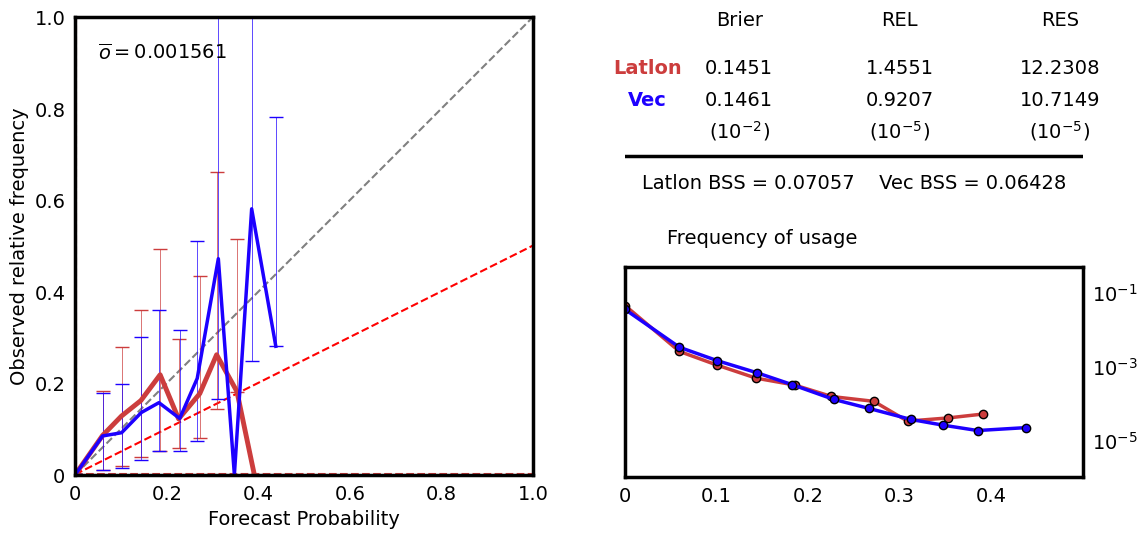

In [182]:
fig = plt.figure(figsize=(13, 6))

gs = gridspec.GridSpec(2, 2, height_ratios=[1, 1], width_ratios=[1, 1])

ax = plt.subplot(gs[:, 0])
ax_freq = plt.subplot(gs[1, 1])
ax_score = plt.subplot(gs[0, 1])

# ===== Histogram axis ===== #
ax = gu.ax_decorate_box(ax)
# no skill line
fake_x = np.linspace(0, 1, 100)
fake_y = 0.5*fake_x + 0.5*o_bar
ax.plot(fake_x, fake_x, linewidth=1.5, linestyle='--', color='0.5')
ax.plot(fake_x, fake_y, linewidth=1.5, linestyle='--', color='r')
# axis ticks
ax.tick_params(axis="both", which="both", labelbottom=True, labelleft=True)
ax.set_xlim([0, 1.0])
ax.set_xticks([0, 0.2, 0.4, 0.6, 0.8, 1.0])
ax.set_xticklabels([0, 0.2, 0.4, 0.6, 0.8, 1.0])
ax.set_ylim([0, 1.0])
ax.set_yticks([0, 0.2, 0.4, 0.6, 0.8, 1.0])
ax.set_yticklabels([0, 0.2, 0.4, 0.6, 0.8, 1.0])
ax.set_aspect('equal')
# axis labels
ax.set_ylabel('Observed relative frequency', fontsize=14)
ax.set_xlabel('Forecast Probability', fontsize=14)

# climatology line
ax.text(0.05, 0.9, r'$\overline{o} = 0.001561$', ha='left', va='bottom', color='k', fontsize=14)
ax.axvline(x=o_bar, ymin=0, ymax=1, linewidth=1.5, linestyle='--', color=red)
ax.axhline(y=o_bar, xmin=0, xmax=1, linewidth=1.5, linestyle='--', color=red)

# ===== Freq of usage axis ===== #
ax_freq = gu.ax_decorate_box(ax_freq)
ax_freq.tick_params(axis="both", which="both", labelbottom=True, labelright=True)
ax_freq.set_xlim([0, 0.5])
ax_freq.set_xticks([0, 0.1, 0.2, 0.3, 0.4])
ax_freq.set_xticklabels([0, 0.1, 0.2, 0.3, 0.4])
ax_freq.set_yscale('log')
ax_freq.set_ylim([1e-6, 0.5])
ax_freq.set_yticks([1e-5, 1e-3, 1e-1])
ax_freq.text(0.15, 3, 'Frequency of usage', ha='center', va='center', fontsize=14)

# # ===== Score axis ===== #
ax_score.set_axis_off()
table_heads = ['Brier', 'REL', 'RES']
locx_heads = [0.25, 0.60, 0.95]
scales = [r'($10^{-2}$)', r'($10^{-5}$)', r'($10^{-5}$)']

for j in range(3):
    ax_score.text(locx_heads[j], 0.93, table_heads[j], ha='center', va='bottom', 
                  fontsize=14, transform=ax_score.transAxes)
    
    ax_score.text(locx_heads[j], 0.45, scales[j], ha='center', va='center', 
              fontsize=14, transform=ax_score.transAxes)
    
ax_score.text(0.05, 0.70, 'Latlon', ha='center', va='bottom', color=red, fontsize=14, fontweight='bold', transform=ax_score.transAxes)

ax_score.text(0.05, 0.55, 'Vec', ha='center', va='bottom', color=blue, fontsize=14, fontweight='bold', transform=ax_score.transAxes)

ax_score.text(locx_heads[0], 0.7, '{:.4f}'.format(bs_best*1e2), ha='center', va='bottom', 
              color='k', fontsize=14, transform=ax_score.transAxes)
ax_score.text(locx_heads[1], 0.7, '{:.4f}'.format(rel_best*1e5), ha='center', va='bottom', 
              color='k', fontsize=14, transform=ax_score.transAxes)
ax_score.text(locx_heads[2], 0.7, '{:.4f}'.format(res_best*1e5), ha='center', va='bottom', 
              color='k', fontsize=14, transform=ax_score.transAxes)

ax_score.text(locx_heads[0], 0.55, '{:.4f}'.format(bs_vec*1e2), ha='center', va='bottom', 
              color='k', fontsize=14, transform=ax_score.transAxes)
ax_score.text(locx_heads[1], 0.55, '{:.4f}'.format(rel_vec*1e5), ha='center', va='bottom', 
              color='k', fontsize=14, transform=ax_score.transAxes)
ax_score.text(locx_heads[2], 0.55, '{:.4f}'.format(res_vec*1e5), ha='center', va='bottom', 
              color='k', fontsize=14, transform=ax_score.transAxes)

ax_score.axhline(y=0.325, xmin=0, xmax=1.25, linewidth=2.5, linestyle='-', color='k')
    
ax_score.text(0.5, 0.2, 'Latlon BSS = 0.07057    Vec BSS = 0.06428', ha='center', va='center', 
              fontsize=14, transform=ax_score.transAxes)

# ===== Calibration curve ===== #

temp_95_best = np.quantile(prob_true_best, 0.9, axis=1)
temp_05_best = np.quantile(prob_true_best, 0.1, axis=1)
error_best = np.array(list(zip(temp_05_best, temp_95_best))).T
ax.errorbar(prob_pred_mean_best, prob_true_mean_best, yerr=error_best, linestyle='-', capsize=5, color=red, linewidth=3.5, elinewidth=0.5)

temp_95_vec = np.quantile(prob_true_vec, 0.9, axis=1)
temp_05_vec = np.quantile(prob_true_vec, 0.1, axis=1)
error_vec = np.array(list(zip(temp_05_vec, temp_95_vec))).T
ax.errorbar(prob_pred_mean_vec, prob_true_mean_vec, yerr=error_vec, linestyle='-', capsize=5, color=blue, linewidth=2.5, elinewidth=0.5)

# ===== Freq of usage curve ===== #
ax_freq.plot(hist_bins_best, use_best, '-o', color=red, linewidth=2.5, ms=6, mec='k', mfc=red)
ax_freq.plot(hist_bins_vec, use_vec, '-o', color=blue, linewidth=2.5, ms=6, mec='k', mfc=blue)

In [123]:
def performance_diagram_calc(y_true, y_pred_calib, N=50):
    thres = np.linspace(0.01, 0.35, N)
    pod = np.empty(N)
    sr = np.empty(N)

    for i, thre in enumerate(thres):
        tn, fp, fn, tp = confusion_matrix(y_true, y_pred_calib>thre).ravel()
        pod[i] = tp / (tp + fn)

        if fp + tp > 1:
            sr[i] = tp / (fp + tp)
        else:
            sr[i] = np.nan
            
    return sr, pod

In [124]:
sr_best, pod_best = performance_diagram_calc(TEST_Y, Y_pred_best, N=50)
sr_vec, pod_vec = performance_diagram_calc(TEST_Y, Y_pred_vec, N=50)

Text(0.5, 1.0, 'Performance diagram with thresholds of (0, 0.3]')

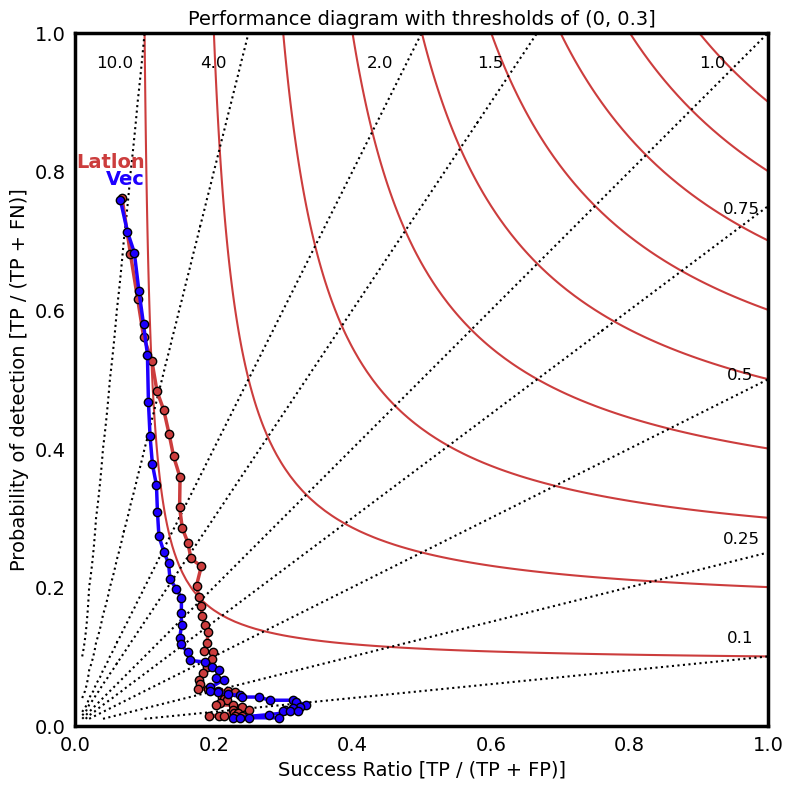

In [127]:
fig = plt.figure(figsize=(9, 9))
ax = fig.gca()

ax.set_xlim([0, 1])
ax.set_ylim([0, 1])

ax = gu.ax_decorate_box(ax)
ax.tick_params(axis="both", which="both", labelbottom=True, labelleft=True)

ax.set_aspect('equal')

x_axis = np.arange(0.01, 1.01, 0.01)
y_axis = np.arange(0.01, 1.01, 0.01)
x_mesh, y_mesh = np.meshgrid(x_axis, y_axis)

csi = ((1 / x_mesh) + (1 / y_mesh) - 1) ** -1
cs_ = ax.contour(x_mesh, y_mesh, csi, np.arange(0.0, 1.1, 0.1), colors=(red,), linestyles='-')

biases = [0.1, 0.25, 0.5, 0.75, 1.0, 1.5, 2.0, 4.0, 10.0]
bias_loc_x = [0.94, 0.935, 0.94, 0.935, 0.9, 0.58, 0.42, 0.18, 0.03]
bias_loc_y = [0.12, 0.2625, 0.5, 0.74, 0.95, 0.95, 0.95, 0.95, 0.95]
bias = y_mesh / x_mesh

ax.contour(x_mesh, y_mesh, bias, biases, colors='k', linestyles=':')

for i, label in enumerate(biases):
    ax.annotate(label, (bias_loc_x[i], bias_loc_y[i]), fontsize=12)

ax.plot(sr_best, pod_best, 'o-', color=red, linewidth=2.5, ms=6, mec='k', mfc=red)
ax.plot(sr_vec, pod_vec, 'o-', color=blue, linewidth=2.5, ms=6, mec='k', mfc=blue)

ax.text(0.1, 0.80, 'Latlon', ha='right', va='bottom', color=red, fontsize=14, fontweight='bold', transform=ax.transAxes)
ax.text(0.1, 0.775, 'Vec', ha='right', va='bottom', color=blue, fontsize=14, fontweight='bold', transform=ax.transAxes)

ax.set_xlabel('Success Ratio [TP / (TP + FP)]', fontsize=14)
ax.set_ylabel('Probability of detection [TP / (TP + FN)]', fontsize=14)

ax.set_title('Performance diagram with thresholds of (0, 0.3]', fontsize=14)

In [184]:
((1 / sr_best) + (1 / pod_best) - 1) ** -1

array([0.06618676, 0.07676349, 0.08518754, 0.09159159, 0.10052678,
       0.10468594, 0.11080022, 0.11416095, 0.11599176, 0.11899314,
       0.1134106 , 0.11131059, 0.1118677 , 0.10948905, 0.11299435,
       0.10352941, 0.10024752, 0.09689922, 0.09299191, 0.08898305,
       0.0863836 , 0.07914764, 0.07332293, 0.07407407, 0.06930693,
       0.0625    , 0.05679862, 0.05105634, 0.04701627, 0.04243542,
       0.04323308, 0.04230769, 0.04288499, 0.04158416, 0.03585657,
       0.03420523, 0.03252033, 0.02868852, 0.02674897, 0.02713987,
       0.02536998, 0.02132196, 0.02150538, 0.01731602, 0.01735358,
       0.01304348, 0.01310044, 0.0131291 , 0.01318681, 0.01321586])

In [128]:
base_v3_s = datetime(2018, 7, 15)
base_v3_e = datetime(2020, 12, 2)

base_v4_s = datetime(2020, 12, 3)
base_v4_e = datetime(2022, 7, 15)

base_ref = datetime(2010, 1, 1)

date_list_v3 = [base_v3_s + timedelta(days=day) for day in range(365+365+142)]
date_list_v4 = [base_v4_s + timedelta(days=day) for day in range(365+180)]

In [185]:
date_list_v3[600]

datetime.datetime(2020, 3, 6, 0, 0)

In [129]:
with h5py.File(save_dir+'HRRR_domain.hdf', 'r') as h5io:
    lon_72km = h5io['lon_80km'][...]
    lat_72km = h5io['lat_80km'][...]
    lon_3km = h5io['lon_3km'][...]
    lat_3km = h5io['lat_3km'][...]
    land_mask_72km = h5io['land_mask_72km'][...]

In [133]:
day_start = 601
day_end = 871
shape_72km = lon_72km.shape

prob_grid = np.empty((day_end-day_start+1,)+shape_72km)
true_grid = np.empty((day_end-day_start+1,)+shape_72km)

prob_grid[...] = np.nan
true_grid[...] = np.nan

for i, name in enumerate(filename_test):
    
    nums = re.findall(r'\d+', name)
    lead = int(nums[-1])
    indy = int(nums[-2])
    indx = int(nums[-3])
    day = int(nums[-4])
    
    prob_grid[day-day_start, indx, indy] = Y_pred_best[i]
    true_grid[day-day_start, indx, indy] = TEST_Y[i]
    

In [135]:
lead = 2

with h5py.File(save_dir_scratch+'SPC_all_lead{}.hdf'.format(lead-2), 'r') as h5io:
    record_1 = h5io['record_v3'][...]
    
with h5py.File(save_dir_scratch+'SPC_all_lead{}.hdf'.format(lead-1), 'r') as h5io:
    record_2 = h5io['record_v3'][...]
    
with h5py.File(save_dir_scratch+'SPC_all_lead{}.hdf'.format(lead), 'r') as h5io:
    record_3 = h5io['record_v3'][...]
    
with h5py.File(save_dir_scratch+'SPC_all_lead{}.hdf'.format(lead+1), 'r') as h5io:
    record_4 = h5io['record_v3'][...]
    
# record_1[np.isnan(record_1)] = 0
# record_2[np.isnan(record_2)] = 0
# record_3[np.isnan(record_3)] = 0
# record_4[np.isnan(record_4)] = 0

record_v3 = np.concatenate((record_1, record_2, record_3, record_4), axis=1)

shape_record = record_v3.shape

In [137]:
def aspc_cal(edge):
    return (edge[3]-edge[2])/(edge[1]-edge[0])

def gcd(a, b):
    if b == 0:
        return a
    else:
        return gcd(b, a % b)

# Cartopy map settings
scale_param = '50m' # 10m for publication quality
# US states and CAN-US boundary
PROVINCE = cfeature.NaturalEarthFeature(
    category='cultural',
    name='admin_1_states_provinces_lines',
    scale=scale_param,
    facecolor='none')

In [138]:
fig_keys = {'dpi':100, 
            'orientation':'portrait', 
            'bbox_inches':'tight', 
            'pad_inches':0.1, 
            'transparent':False}

In [139]:
edge = [-128, -70, 25, 50]

In [142]:
fig_dir

'/glade/u/home/ksha/figures/'

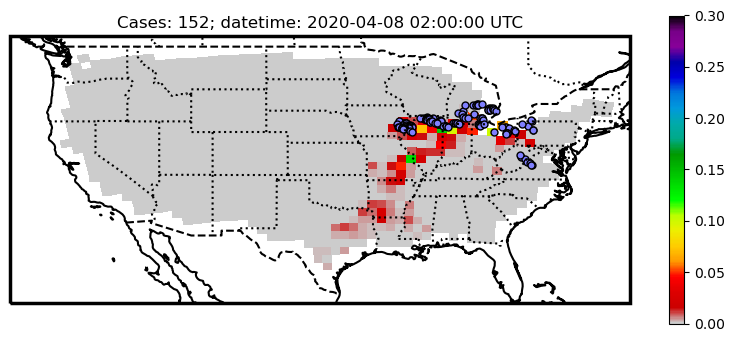

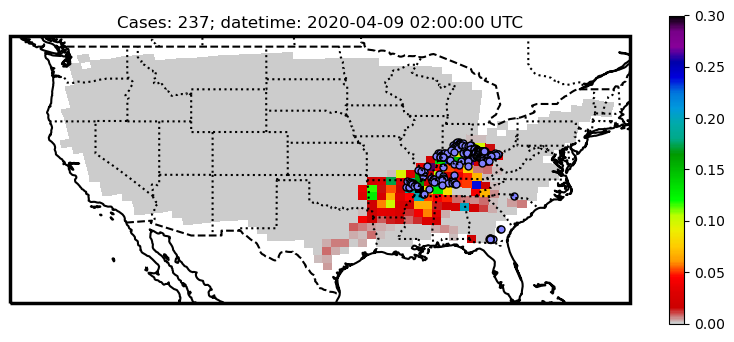

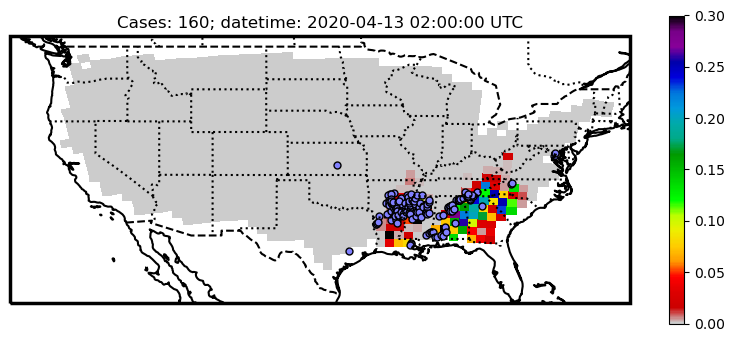

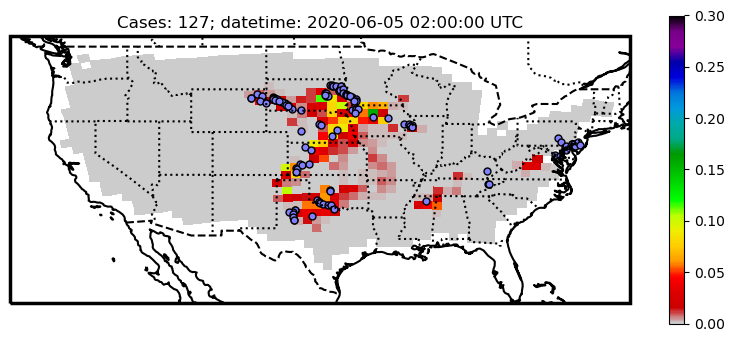

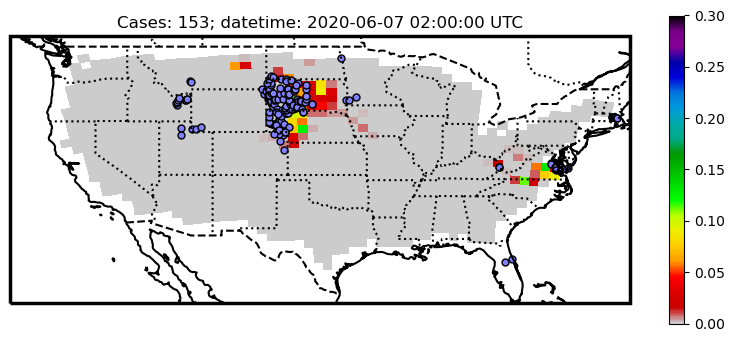

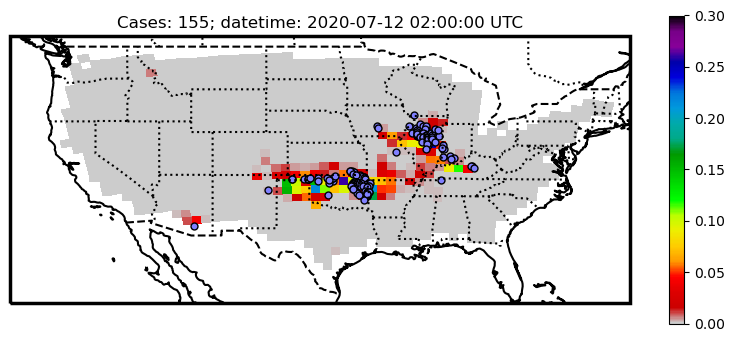

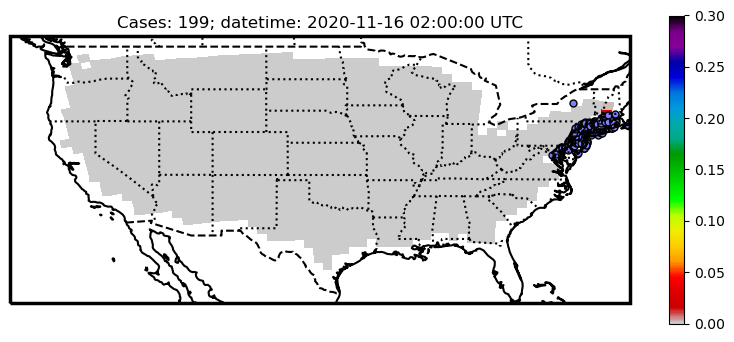

In [205]:
for day in range(day_start, day_end, 1):

    # dt_temp = date_list_v3[day]
    # dt_year = dt_temp.year
    # dt_nday = (dt_temp - datetime(dt_year, 1, 1)).days

    record_temp = record_v3[day, ...]

    lon_temp = []
    lat_temp = []

    for f in range(int(shape_record[-1]/2)):
        if np.logical_not(np.isnan(record_temp[2*f])):
            lon_temp.append(record_temp[2*f])
            lat_temp.append(record_temp[2*f+1])
    
    N_case = len(lon_temp)
    
    if N_case > 100:
        
        fig = plt.figure(figsize=(10, 4))
        ax = plt.axes(projection=ccrs.PlateCarree())

        ax.set_extent(edge, ccrs.PlateCarree())
        ax.add_feature(cfeature.COASTLINE.with_scale(scale_param), edgecolor='k', linewidth=1.5, zorder=6)
        ax.add_feature(cfeature.BORDERS.with_scale(scale_param), linestyle='--', linewidth=1.5, zorder=6)
        ax.add_feature(PROVINCE, edgecolor='k', linestyle=':', linewidth=1.5, zorder=5)

        ax.spines['geo'].set_linewidth(2.5)

        CS = ax.pcolormesh(lon_72km, lat_72km, prob_grid[day-day_start, ...], vmin=0, vmax=0.3, cmap=plt.cm.nipy_spectral_r)
        ax.plot(lon_temp, lat_temp, 'ko', ms=5, mec='k', mew=1.0, mfc=[0.5, 0.5, 1.0])
        ax.set_title('Cases: {}; datetime: {} UTC'.format(N_case, date_list_v3[day]+timedelta(hours=lead)))
        ax.set_xlabel('lon', fontsize=14)
        ax.set_ylabel('lat', fontsize=14)
        plt.colorbar(CS)

        # fig.savefig(fig_dir+'example_output_day{}.png'.format(day), format='png', **fig_keys)

In [ ]:
TEST_Y 